# Plants Calssfication according to number of leaves

Topics Covered in this notebook:
- Training CNNs
- Problem reformulation
- Techniques for improving results (Regularization, Data Augmentation)



### importing libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D
from sklearn.metrics import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2022-11-27 13:05:28.071855: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-27 13:05:28.202336: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mennatallah/turtle_ws/devel/lib:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu
2022-11-27 13:05:28.202371: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-27 13:05:28.857783: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic lib

## Part 0. Data Preparation

The data are plant images at different resolutions captured with a variety of cameras. There are images showing plants with approximatelty 1,2,3,4 and 6 leafs. The images are part of a Leaf counting dataset by Teimouri et al. [1] which can be downloaded from the Aarhus University, Denmark:

<a href="https://vision.eng.au.dk/leaf-counting-dataset/">Leaf counting dataset</a> 




In this section:
<ul>
<li>Download the dataset as described above</li>
<li>Use the splits provided in the Brightspace files</li>
<li>Visualize five images from the dataset.</li>
</ul>


global variables

In [ ]:
epoch_num = 50
batch = 64

function to scale the images

In [ ]:
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

Importing the data

In [ ]:
# Prepare your dataset here
train_data_org=  tf.keras.utils.image_dataset_from_directory(
                    directory='training',
                    labels='inferred',
                    label_mode='int',
                    color_mode='rgb',
                    batch_size=64,
                    image_size=(32, 32),
                    shuffle=True,
                    seed=7,
                    validation_split=0.2,
                    subset="training",
                    interpolation='bilinear',
                    follow_links=False,
                    crop_to_aspect_ratio=False,
                )
train_data = train_data_org.map(process)

validate_data_org=  tf.keras.utils.image_dataset_from_directory(
                    directory='training',
                    labels='inferred',
                    label_mode='int',
                    color_mode='rgb',
                    batch_size=64,
                    image_size=(32, 32),
                    shuffle=True,
                    seed=7,
                    validation_split=0.2,
                    subset="validation",
                    interpolation='bilinear',
                    follow_links=False,
                    crop_to_aspect_ratio=False,
                )
validate_data = validate_data_org.map(process)

test_data_org=  tf.keras.utils.image_dataset_from_directory(
                    directory='testing',
                    labels='inferred',
                    label_mode='int',
                    color_mode='rgb',
                    batch_size=64,
                    image_size=(32, 32),
                    shuffle=True,
                    seed=None,
                    validation_split=None,
                    subset=None,
                    interpolation='bilinear',
                    follow_links=False,
                    crop_to_aspect_ratio=False,
                )
test_data = test_data_org.map(process)

Found 900 files belonging to 5 classes.
Using 720 files for training.
Found 900 files belonging to 5 classes.
Using 180 files for validation.
Found 100 files belonging to 5 classes.


2022-11-27 13:05:30.197027: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mennatallah/turtle_ws/devel/lib:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu
2022-11-27 13:05:30.197044: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-27 13:05:30.197059: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mennatallah-OptiPlex-3070): /proc/driver/nvidia/version does not exist
2022-11-27 13:05:30.197247: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, r

Plotting the images

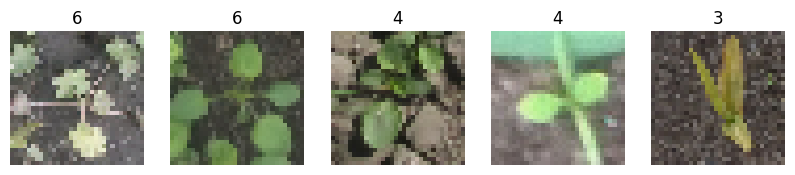

In [ ]:
plt.figure(figsize=(10, 50))
class_names = train_data_org.class_names
for images, labels in test_data_org.take(1):
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Part 1a. Transfer Learning - Classification Network 
Keras implementation of VGG-16. 

Using the first 2 blocks of VGG-16 add extra Keras layers to create your own version of a CNN network for the classification of the images according to the number of leaves in the plant images.

- You can use as many pooling, flattening, 1 × 1 convolution layers, etc. as you wish but do not use any regularization.
- Train this simple network on the training set while monitoring convergence on the validation set.
- As input to the model use images of size no larger than 128×128.



importing VGG 16

In [ ]:
# Write your code here
vgg_16 = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(32,32,3),
    pooling='avg',
    classes=5,
)

vgg_16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

Taking the first 2 blocks

In [ ]:
vgg_16_required = keras.Model(vgg_16.input,vgg_16.get_layer('block2_pool').output)
for layer in vgg_16_required.layers:
    layer.trainable = False
vgg_16_required.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

Forming the model

In [ ]:
vgg16_transfer_clf = Sequential()
vgg16_transfer_clf.add(vgg_16_required)
vgg16_transfer_clf.add(Conv2D(filters=256, kernel_size=(8,8), padding="same", activation='relu'))
vgg16_transfer_clf.add(Conv2D(filters=512, kernel_size=(4,4), padding="same", activation='relu'))
vgg16_transfer_clf.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
vgg16_transfer_clf.add(Conv2D(filters=512, kernel_size=(2,2), padding="same", activation='relu'))
vgg16_transfer_clf.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
vgg16_transfer_clf.add(Flatten())
vgg16_transfer_clf.add(Dense(64, activation='relu'))
vgg16_transfer_clf.add(Dense(5, activation='softmax'))
vgg16_transfer_clf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 8, 8, 128)         260160    
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 256)         2097408   
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 512)         2097664   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 512)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 512)         1049088   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 512)        0         
 2D)                                                    

In [ ]:
vgg16_transfer_clf.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-06), metrics=['accuracy'])

To save the model weights

In [ ]:
vgg16_transfer_clf_cb=tf.keras.callbacks.ModelCheckpoint(
    filepath="./weights/vgg16_transfer_clf",
    monitor = "val_loss",
    verbose = 0,
    save_best_only= False,
    save_weights_only= False,
    mode= "auto",
    save_freq="epoch",
    options=None,
    initial_value_threshold=None,
)

Trainning the model

In [ ]:
vgg16_transfer_clf_op=vgg16_transfer_clf.fit(train_data, epochs=epoch_num, batch_size=batch,validation_data=validate_data, callbacks=[vgg16_transfer_clf_cb],shuffle=False)

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 3.5885 - accuracy: 0.1778

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 12s 901ms/step - loss: 3.5885 - accuracy: 0.1778 - val_loss: 3.0732 - val_accuracy: 0.1722
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 2.6474 - accuracy: 0.1611

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 10s 830ms/step - loss: 2.6474 - accuracy: 0.1611 - val_loss: 2.4308 - val_accuracy: 0.1611
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 2.1469 - accuracy: 0.1764

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 9s 747ms/step - loss: 2.1469 - accuracy: 0.1764 - val_loss: 2.1051 - val_accuracy: 0.1722
Epoch 4/50
12/12 [==============================] - ETA: 0s - loss: 1.8631 - accuracy: 0.1986

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 9s 767ms/step - loss: 1.8631 - accuracy: 0.1986 - val_loss: 1.9231 - val_accuracy: 0.1833
Epoch 5/50
12/12 [==============================] - ETA: 0s - loss: 1.7050 - accuracy: 0.2236

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 10s 863ms/step - loss: 1.7050 - accuracy: 0.2236 - val_loss: 1.8281 - val_accuracy: 0.1778
Epoch 6/50
12/12 [==============================] - ETA: 0s - loss: 1.6519 - accuracy: 0.2500

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 10s 789ms/step - loss: 1.6519 - accuracy: 0.2500 - val_loss: 1.8045 - val_accuracy: 0.1722
Epoch 7/50
12/12 [==============================] - ETA: 0s - loss: 1.6035 - accuracy: 0.2736

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 9s 756ms/step - loss: 1.6035 - accuracy: 0.2736 - val_loss: 1.7769 - val_accuracy: 0.1778
Epoch 8/50
12/12 [==============================] - ETA: 0s - loss: 1.5611 - accuracy: 0.2889

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 11s 915ms/step - loss: 1.5611 - accuracy: 0.2889 - val_loss: 1.7769 - val_accuracy: 0.1778
Epoch 9/50
12/12 [==============================] - ETA: 0s - loss: 1.5237 - accuracy: 0.2958

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 11s 884ms/step - loss: 1.5237 - accuracy: 0.2958 - val_loss: 1.7656 - val_accuracy: 0.1889
Epoch 10/50
12/12 [==============================] - ETA: 0s - loss: 1.4861 - accuracy: 0.3444

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 11s 892ms/step - loss: 1.4861 - accuracy: 0.3444 - val_loss: 1.7511 - val_accuracy: 0.1833
Epoch 11/50
12/12 [==============================] - ETA: 0s - loss: 1.4523 - accuracy: 0.3778

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 12s 1s/step - loss: 1.4523 - accuracy: 0.3778 - val_loss: 1.7409 - val_accuracy: 0.2111
Epoch 12/50
12/12 [==============================] - ETA: 0s - loss: 1.4205 - accuracy: 0.3986

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 10s 819ms/step - loss: 1.4205 - accuracy: 0.3986 - val_loss: 1.7348 - val_accuracy: 0.2167
Epoch 13/50
12/12 [==============================] - ETA: 0s - loss: 1.3866 - accuracy: 0.4194

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 12s 1s/step - loss: 1.3866 - accuracy: 0.4194 - val_loss: 1.7314 - val_accuracy: 0.2333
Epoch 14/50
12/12 [==============================] - ETA: 0s - loss: 1.3594 - accuracy: 0.4278

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 11s 877ms/step - loss: 1.3594 - accuracy: 0.4278 - val_loss: 1.7232 - val_accuracy: 0.2333
Epoch 15/50
12/12 [==============================] - ETA: 0s - loss: 1.3318 - accuracy: 0.4736

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 12s 962ms/step - loss: 1.3318 - accuracy: 0.4736 - val_loss: 1.7124 - val_accuracy: 0.2222
Epoch 16/50
12/12 [==============================] - ETA: 0s - loss: 1.2994 - accuracy: 0.4861

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 11s 892ms/step - loss: 1.2994 - accuracy: 0.4861 - val_loss: 1.7113 - val_accuracy: 0.2278
Epoch 17/50
12/12 [==============================] - ETA: 0s - loss: 1.2716 - accuracy: 0.5042

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 10s 815ms/step - loss: 1.2716 - accuracy: 0.5042 - val_loss: 1.6988 - val_accuracy: 0.2389
Epoch 18/50
12/12 [==============================] - ETA: 0s - loss: 1.2449 - accuracy: 0.5250

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 11s 923ms/step - loss: 1.2449 - accuracy: 0.5250 - val_loss: 1.6974 - val_accuracy: 0.2278
Epoch 19/50
12/12 [==============================] - ETA: 0s - loss: 1.2222 - accuracy: 0.5417

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 10s 780ms/step - loss: 1.2222 - accuracy: 0.5417 - val_loss: 1.6879 - val_accuracy: 0.2444
Epoch 20/50
12/12 [==============================] - ETA: 0s - loss: 1.1938 - accuracy: 0.5639

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 10s 786ms/step - loss: 1.1938 - accuracy: 0.5639 - val_loss: 1.6844 - val_accuracy: 0.2500
Epoch 21/50
12/12 [==============================] - ETA: 0s - loss: 1.1718 - accuracy: 0.5806

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 11s 887ms/step - loss: 1.1718 - accuracy: 0.5806 - val_loss: 1.6773 - val_accuracy: 0.2500
Epoch 22/50
12/12 [==============================] - ETA: 0s - loss: 1.1469 - accuracy: 0.6028

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 10s 830ms/step - loss: 1.1469 - accuracy: 0.6028 - val_loss: 1.6772 - val_accuracy: 0.2500
Epoch 23/50
12/12 [==============================] - ETA: 0s - loss: 1.1239 - accuracy: 0.6236

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 10s 816ms/step - loss: 1.1239 - accuracy: 0.6236 - val_loss: 1.6673 - val_accuracy: 0.2444
Epoch 24/50
12/12 [==============================] - ETA: 0s - loss: 1.1023 - accuracy: 0.6375

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 11s 878ms/step - loss: 1.1023 - accuracy: 0.6375 - val_loss: 1.6651 - val_accuracy: 0.2556
Epoch 25/50
12/12 [==============================] - ETA: 0s - loss: 1.0788 - accuracy: 0.6528

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 10s 803ms/step - loss: 1.0788 - accuracy: 0.6528 - val_loss: 1.6577 - val_accuracy: 0.2722
Epoch 26/50
12/12 [==============================] - ETA: 0s - loss: 1.0605 - accuracy: 0.6667

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 10s 828ms/step - loss: 1.0605 - accuracy: 0.6667 - val_loss: 1.6517 - val_accuracy: 0.2556
Epoch 27/50
12/12 [==============================] - ETA: 0s - loss: 1.0370 - accuracy: 0.6819

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 11s 870ms/step - loss: 1.0370 - accuracy: 0.6819 - val_loss: 1.6466 - val_accuracy: 0.2500
Epoch 28/50
12/12 [==============================] - ETA: 0s - loss: 1.0176 - accuracy: 0.7028

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 10s 835ms/step - loss: 1.0176 - accuracy: 0.7028 - val_loss: 1.6424 - val_accuracy: 0.2722
Epoch 29/50
12/12 [==============================] - ETA: 0s - loss: 0.9964 - accuracy: 0.7125

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 10s 821ms/step - loss: 0.9964 - accuracy: 0.7125 - val_loss: 1.6419 - val_accuracy: 0.2667
Epoch 30/50
12/12 [==============================] - ETA: 0s - loss: 0.9779 - accuracy: 0.7278

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 11s 900ms/step - loss: 0.9779 - accuracy: 0.7278 - val_loss: 1.6354 - val_accuracy: 0.2722
Epoch 31/50
12/12 [==============================] - ETA: 0s - loss: 0.9573 - accuracy: 0.7403

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 11s 878ms/step - loss: 0.9573 - accuracy: 0.7403 - val_loss: 1.6327 - val_accuracy: 0.2722
Epoch 32/50
12/12 [==============================] - ETA: 0s - loss: 0.9392 - accuracy: 0.7667

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 10s 803ms/step - loss: 0.9392 - accuracy: 0.7667 - val_loss: 1.6296 - val_accuracy: 0.2722
Epoch 33/50
12/12 [==============================] - ETA: 0s - loss: 0.9244 - accuracy: 0.7542

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 11s 870ms/step - loss: 0.9244 - accuracy: 0.7542 - val_loss: 1.6200 - val_accuracy: 0.2944
Epoch 34/50
12/12 [==============================] - ETA: 0s - loss: 0.9049 - accuracy: 0.7819

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 11s 877ms/step - loss: 0.9049 - accuracy: 0.7819 - val_loss: 1.6223 - val_accuracy: 0.2722
Epoch 35/50
12/12 [==============================] - ETA: 0s - loss: 0.8865 - accuracy: 0.8028

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 10s 807ms/step - loss: 0.8865 - accuracy: 0.8028 - val_loss: 1.6138 - val_accuracy: 0.2778
Epoch 36/50
12/12 [==============================] - ETA: 0s - loss: 0.8711 - accuracy: 0.7972

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 11s 906ms/step - loss: 0.8711 - accuracy: 0.7972 - val_loss: 1.6116 - val_accuracy: 0.2889
Epoch 37/50
12/12 [==============================] - ETA: 0s - loss: 0.8528 - accuracy: 0.8236

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 10s 847ms/step - loss: 0.8528 - accuracy: 0.8236 - val_loss: 1.6122 - val_accuracy: 0.2833
Epoch 38/50
12/12 [==============================] - ETA: 0s - loss: 0.8391 - accuracy: 0.8264

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 10s 813ms/step - loss: 0.8391 - accuracy: 0.8264 - val_loss: 1.6046 - val_accuracy: 0.3056
Epoch 39/50
12/12 [==============================] - ETA: 0s - loss: 0.8229 - accuracy: 0.8361

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 11s 881ms/step - loss: 0.8229 - accuracy: 0.8361 - val_loss: 1.6053 - val_accuracy: 0.2889
Epoch 40/50
12/12 [==============================] - ETA: 0s - loss: 0.8063 - accuracy: 0.8417

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 10s 787ms/step - loss: 0.8063 - accuracy: 0.8417 - val_loss: 1.5964 - val_accuracy: 0.3056
Epoch 41/50
12/12 [==============================] - ETA: 0s - loss: 0.7904 - accuracy: 0.8514

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 9s 771ms/step - loss: 0.7904 - accuracy: 0.8514 - val_loss: 1.5998 - val_accuracy: 0.3056
Epoch 42/50
12/12 [==============================] - ETA: 0s - loss: 0.7762 - accuracy: 0.8597

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 10s 845ms/step - loss: 0.7762 - accuracy: 0.8597 - val_loss: 1.5945 - val_accuracy: 0.2944
Epoch 43/50
12/12 [==============================] - ETA: 0s - loss: 0.7630 - accuracy: 0.8611

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 9s 766ms/step - loss: 0.7630 - accuracy: 0.8611 - val_loss: 1.5950 - val_accuracy: 0.3056
Epoch 44/50
12/12 [==============================] - ETA: 0s - loss: 0.7485 - accuracy: 0.8750

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 9s 768ms/step - loss: 0.7485 - accuracy: 0.8750 - val_loss: 1.5883 - val_accuracy: 0.3056
Epoch 45/50
12/12 [==============================] - ETA: 0s - loss: 0.7373 - accuracy: 0.8792

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 10s 837ms/step - loss: 0.7373 - accuracy: 0.8792 - val_loss: 1.5885 - val_accuracy: 0.3056
Epoch 46/50
12/12 [==============================] - ETA: 0s - loss: 0.7211 - accuracy: 0.8861

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 10s 811ms/step - loss: 0.7211 - accuracy: 0.8861 - val_loss: 1.5881 - val_accuracy: 0.3000
Epoch 47/50
12/12 [==============================] - ETA: 0s - loss: 0.7077 - accuracy: 0.8958

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 9s 750ms/step - loss: 0.7077 - accuracy: 0.8958 - val_loss: 1.5807 - val_accuracy: 0.3278
Epoch 48/50
12/12 [==============================] - ETA: 0s - loss: 0.6953 - accuracy: 0.9014

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 10s 816ms/step - loss: 0.6953 - accuracy: 0.9014 - val_loss: 1.5783 - val_accuracy: 0.3167
Epoch 49/50
12/12 [==============================] - ETA: 0s - loss: 0.6837 - accuracy: 0.9069

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 9s 772ms/step - loss: 0.6837 - accuracy: 0.9069 - val_loss: 1.5823 - val_accuracy: 0.3000
Epoch 50/50
12/12 [==============================] - ETA: 0s - loss: 0.6712 - accuracy: 0.9097

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_clf/assets


12/12 [==============================] - 9s 735ms/step - loss: 0.6712 - accuracy: 0.9097 - val_loss: 1.5734 - val_accuracy: 0.3222


### Plotting the loss

(50, 1)


/tmp/ipykernel_9786/1153161727.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


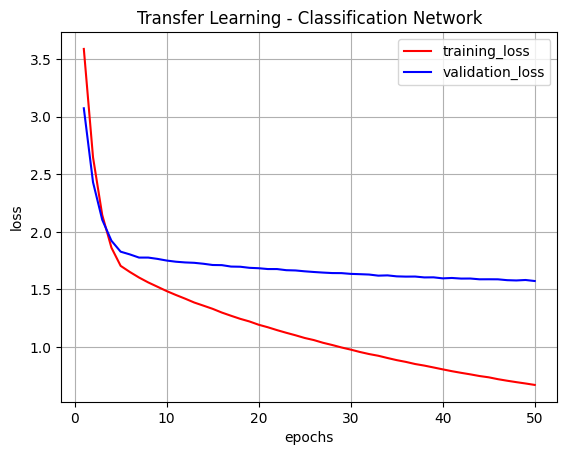

In [ ]:
training_loss = vgg16_transfer_clf_op.history['loss']
val_loss=vgg16_transfer_clf_op.history['val_loss']
training_loss = np.reshape(training_loss, (epoch_num,1))
val_loss = np.reshape(val_loss, (epoch_num,1))

print(np.shape(val_loss))

plt.plot(range(1,epoch_num+1),training_loss,color = 'red' ,label = "training_loss")
plt.plot(range(1,epoch_num+1),val_loss,color = 'blue', label = "validation_loss")

plt.title("Transfer Learning - Classification Network")
plt.xlabel('epochs')
plt.ylabel('loss')

plt.grid(b=True)
plt.legend()
plt.show()

### plotting the accuracy

/tmp/ipykernel_9786/1956982152.py:13: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


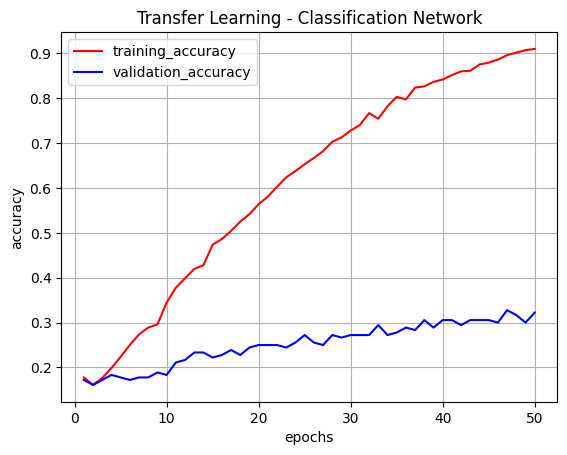

In [ ]:
training_acc = vgg16_transfer_clf_op.history['accuracy']
val_acc=vgg16_transfer_clf_op.history['val_accuracy']
training_acc = np.reshape(training_acc, (epoch_num,1))
val_acc = np.reshape(val_acc, (epoch_num,1))

plt.plot(range(1,epoch_num+1),training_acc,color = 'red' ,label = "training_accuracy")
plt.plot(range(1,epoch_num+1),val_acc,color = 'blue', label = "validation_accuracy")

plt.title("Transfer Learning - Classification Network")
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.grid(b=True)
plt.legend()
plt.show()

### plotting the confusion matricies

In [ ]:
def cm_clf (case):
  if case == "testing":
    data = test_data
  elif case == "training":
    data = train_data
  elif case == "validation":
    data = validate_data

  predictions = vgg16_transfer_clf.predict(data)    
  y_pred = np.argmax(predictions,axis=1)
  y = np.concatenate([y for x, y in data], axis=0)

  print("accuracy",accuracy_score(y, y_pred))

  cm_s =confusion_matrix(y, y_pred)
  disp_s = ConfusionMatrixDisplay(confusion_matrix=cm_s, display_labels=[1,2,3,4,6])
  disp_s.plot(cmap=plt.cm.BuPu)
  plt.title('%s confusion matrix'%(case), size=16)


2/2 [==============================] - 0s 67ms/step
accuracy 0.2


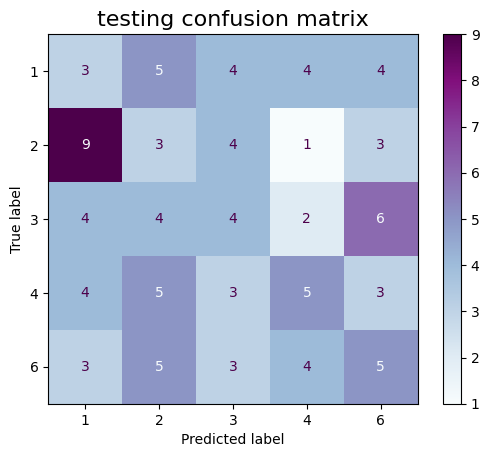

In [ ]:
cm_clf("testing")

12/12 [==============================] - 2s 93ms/step
accuracy 0.20694444444444443


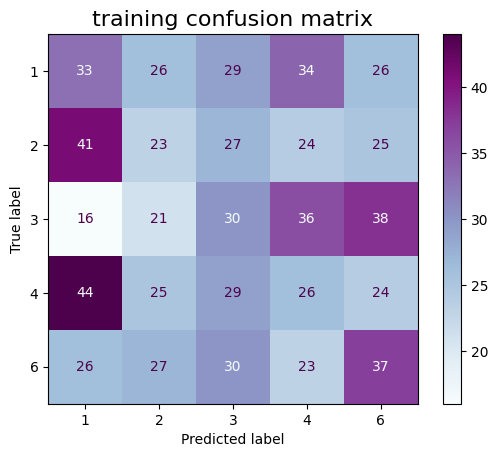

In [ ]:
cm_clf("training")

3/3 [==============================] - 0s 96ms/step
accuracy 0.25555555555555554


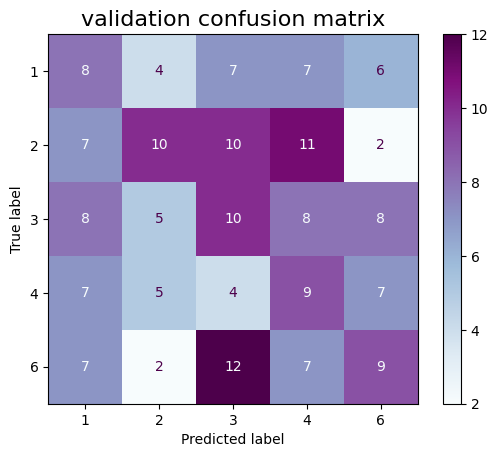

In [ ]:
cm_clf("validation")

## Part 1b. Transfer Learning - Regression Reformulation 

### Step 1 (2)
Repeat the steps of Part 1a. but reformulate as a regression problem, i.e., your network needs to output a single float value ranging between 0 to 6 corresponding to the number of leaves.

### Step 2 (1)
The size of the training data is quite small. Discuss based on your learning curves if overfitting is occurring with the models from Parts 1a and 1b.

In [ ]:
vgg16_transfer_reg = Sequential()
leaky_relu = tf.keras.layers.LeakyReLU()
vgg16_transfer_reg.add(vgg_16_required)
vgg16_transfer_reg.add(Conv2D(filters=256, kernel_size=(8,8), padding="same", activation='relu'))
vgg16_transfer_reg.add(Conv2D(filters=512, kernel_size=(4,4), padding="same", activation='relu'))
vgg16_transfer_reg.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
vgg16_transfer_reg.add(Conv2D(filters=512, kernel_size=(2,2), padding="same", activation='relu'))
vgg16_transfer_reg.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
vgg16_transfer_reg.add(Flatten())
vgg16_transfer_reg.add(Dense(64, activation='relu'))
relu4 =tf.keras.layers.ReLU(max_value=4)
vgg16_transfer_reg.add(Dense(1, activation='linear'))
vgg16_transfer_reg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 8, 8, 128)         260160    
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 256)         2097408   
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 512)         2097664   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 512)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 512)         1049088   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 2, 2, 512)        0         
 2D)                                                  

In [ ]:
vgg16_transfer_reg.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-06), metrics=['accuracy'])

In [ ]:
vgg16_transfer_reg_cb=tf.keras.callbacks.ModelCheckpoint(
    filepath="./weights/vgg16_transfer_reg",
    monitor = "val_loss",
    verbose = 0,
    save_best_only= False,
    save_weights_only= False,
    mode= "auto",
    save_freq="epoch",
    options=None,
    initial_value_threshold=None,
)

In [ ]:
vgg16_transfer_reg_op=vgg16_transfer_reg.fit(train_data, epochs=epoch_num, batch_size=batch,validation_data=validate_data, callbacks=[vgg16_transfer_reg_cb], shuffle=False)

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 3.5102 - accuracy: 0.1847

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 9s 715ms/step - loss: 3.5102 - accuracy: 0.1847 - val_loss: 2.6375 - val_accuracy: 0.2222
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 2.9311 - accuracy: 0.1931

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 8s 652ms/step - loss: 2.9311 - accuracy: 0.1931 - val_loss: 2.2604 - val_accuracy: 0.2167
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 2.4675 - accuracy: 0.1944

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 8s 660ms/step - loss: 2.4675 - accuracy: 0.1944 - val_loss: 2.2379 - val_accuracy: 0.2222
Epoch 4/50
12/12 [==============================] - ETA: 0s - loss: 2.1982 - accuracy: 0.1944

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 8s 640ms/step - loss: 2.1982 - accuracy: 0.1944 - val_loss: 2.0916 - val_accuracy: 0.2222
Epoch 5/50
12/12 [==============================] - ETA: 0s - loss: 2.0270 - accuracy: 0.2028

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 11s 921ms/step - loss: 2.0270 - accuracy: 0.2028 - val_loss: 2.0884 - val_accuracy: 0.2222
Epoch 6/50
12/12 [==============================] - ETA: 0s - loss: 1.8734 - accuracy: 0.2028

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 9s 747ms/step - loss: 1.8734 - accuracy: 0.2028 - val_loss: 1.9996 - val_accuracy: 0.2222
Epoch 7/50
12/12 [==============================] - ETA: 0s - loss: 1.7254 - accuracy: 0.2042

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 9s 741ms/step - loss: 1.7254 - accuracy: 0.2042 - val_loss: 1.9580 - val_accuracy: 0.2222
Epoch 8/50
12/12 [==============================] - ETA: 0s - loss: 1.6304 - accuracy: 0.2069

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 10s 818ms/step - loss: 1.6304 - accuracy: 0.2069 - val_loss: 1.9228 - val_accuracy: 0.2222
Epoch 9/50
12/12 [==============================] - ETA: 0s - loss: 1.5006 - accuracy: 0.2042

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 9s 764ms/step - loss: 1.5006 - accuracy: 0.2042 - val_loss: 1.8895 - val_accuracy: 0.2222
Epoch 10/50
12/12 [==============================] - ETA: 0s - loss: 1.3876 - accuracy: 0.2069

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 9s 741ms/step - loss: 1.3876 - accuracy: 0.2069 - val_loss: 1.8621 - val_accuracy: 0.2278
Epoch 11/50
12/12 [==============================] - ETA: 0s - loss: 1.2862 - accuracy: 0.2111

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 10s 831ms/step - loss: 1.2862 - accuracy: 0.2111 - val_loss: 1.8149 - val_accuracy: 0.2278
Epoch 12/50
12/12 [==============================] - ETA: 0s - loss: 1.1997 - accuracy: 0.2097

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 9s 750ms/step - loss: 1.1997 - accuracy: 0.2097 - val_loss: 1.8029 - val_accuracy: 0.2500
Epoch 13/50
12/12 [==============================] - ETA: 0s - loss: 1.1191 - accuracy: 0.2194

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 9s 754ms/step - loss: 1.1191 - accuracy: 0.2194 - val_loss: 1.7609 - val_accuracy: 0.2444
Epoch 14/50
12/12 [==============================] - ETA: 0s - loss: 1.0452 - accuracy: 0.2236

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 10s 841ms/step - loss: 1.0452 - accuracy: 0.2236 - val_loss: 1.7317 - val_accuracy: 0.2444
Epoch 15/50
12/12 [==============================] - ETA: 0s - loss: 0.9708 - accuracy: 0.2194

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 9s 756ms/step - loss: 0.9708 - accuracy: 0.2194 - val_loss: 1.7348 - val_accuracy: 0.2611
Epoch 16/50
12/12 [==============================] - ETA: 0s - loss: 0.9087 - accuracy: 0.2264

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 9s 775ms/step - loss: 0.9087 - accuracy: 0.2264 - val_loss: 1.6942 - val_accuracy: 0.2500
Epoch 17/50
12/12 [==============================] - ETA: 0s - loss: 0.8548 - accuracy: 0.2208

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 10s 796ms/step - loss: 0.8548 - accuracy: 0.2208 - val_loss: 1.7000 - val_accuracy: 0.2611
Epoch 18/50
12/12 [==============================] - ETA: 0s - loss: 0.7972 - accuracy: 0.2306

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 9s 754ms/step - loss: 0.7972 - accuracy: 0.2306 - val_loss: 1.6605 - val_accuracy: 0.2556
Epoch 19/50
12/12 [==============================] - ETA: 0s - loss: 0.7494 - accuracy: 0.2292

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 10s 797ms/step - loss: 0.7494 - accuracy: 0.2292 - val_loss: 1.6794 - val_accuracy: 0.2556
Epoch 20/50
12/12 [==============================] - ETA: 0s - loss: 0.7064 - accuracy: 0.2403

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 9s 741ms/step - loss: 0.7064 - accuracy: 0.2403 - val_loss: 1.6310 - val_accuracy: 0.2556
Epoch 21/50
12/12 [==============================] - ETA: 0s - loss: 0.6576 - accuracy: 0.2500

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 10s 828ms/step - loss: 0.6576 - accuracy: 0.2500 - val_loss: 1.6325 - val_accuracy: 0.2556
Epoch 22/50
12/12 [==============================] - ETA: 0s - loss: 0.6200 - accuracy: 0.2458

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 9s 766ms/step - loss: 0.6200 - accuracy: 0.2458 - val_loss: 1.6246 - val_accuracy: 0.2556
Epoch 23/50
12/12 [==============================] - ETA: 0s - loss: 0.5863 - accuracy: 0.2653

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 10s 790ms/step - loss: 0.5863 - accuracy: 0.2653 - val_loss: 1.6021 - val_accuracy: 0.2556
Epoch 24/50
12/12 [==============================] - ETA: 0s - loss: 0.5479 - accuracy: 0.2597

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 10s 811ms/step - loss: 0.5479 - accuracy: 0.2597 - val_loss: 1.6145 - val_accuracy: 0.2611
Epoch 25/50
12/12 [==============================] - ETA: 0s - loss: 0.5094 - accuracy: 0.2708

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 10s 820ms/step - loss: 0.5094 - accuracy: 0.2708 - val_loss: 1.5821 - val_accuracy: 0.2556
Epoch 26/50
12/12 [==============================] - ETA: 0s - loss: 0.4930 - accuracy: 0.2667

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 11s 852ms/step - loss: 0.4930 - accuracy: 0.2667 - val_loss: 1.5967 - val_accuracy: 0.2611
Epoch 27/50
12/12 [==============================] - ETA: 0s - loss: 0.4503 - accuracy: 0.2764

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 10s 801ms/step - loss: 0.4503 - accuracy: 0.2764 - val_loss: 1.5723 - val_accuracy: 0.2556
Epoch 28/50
12/12 [==============================] - ETA: 0s - loss: 0.4251 - accuracy: 0.2792

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 10s 769ms/step - loss: 0.4251 - accuracy: 0.2792 - val_loss: 1.5676 - val_accuracy: 0.2556
Epoch 29/50
12/12 [==============================] - ETA: 0s - loss: 0.4007 - accuracy: 0.2903

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 10s 786ms/step - loss: 0.4007 - accuracy: 0.2903 - val_loss: 1.5600 - val_accuracy: 0.2556
Epoch 30/50
12/12 [==============================] - ETA: 0s - loss: 0.3796 - accuracy: 0.2931

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 10s 824ms/step - loss: 0.3796 - accuracy: 0.2931 - val_loss: 1.5696 - val_accuracy: 0.2611
Epoch 31/50
12/12 [==============================] - ETA: 0s - loss: 0.3542 - accuracy: 0.3042

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 10s 807ms/step - loss: 0.3542 - accuracy: 0.3042 - val_loss: 1.5466 - val_accuracy: 0.2556
Epoch 32/50
12/12 [==============================] - ETA: 0s - loss: 0.3331 - accuracy: 0.3083

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 10s 777ms/step - loss: 0.3331 - accuracy: 0.3083 - val_loss: 1.5434 - val_accuracy: 0.2556
Epoch 33/50
12/12 [==============================] - ETA: 0s - loss: 0.3132 - accuracy: 0.3125

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 10s 839ms/step - loss: 0.3132 - accuracy: 0.3125 - val_loss: 1.5423 - val_accuracy: 0.2611
Epoch 34/50
12/12 [==============================] - ETA: 0s - loss: 0.2958 - accuracy: 0.3250

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 10s 864ms/step - loss: 0.2958 - accuracy: 0.3250 - val_loss: 1.5317 - val_accuracy: 0.2556
Epoch 35/50
12/12 [==============================] - ETA: 0s - loss: 0.2820 - accuracy: 0.3167

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 10s 811ms/step - loss: 0.2820 - accuracy: 0.3167 - val_loss: 1.5411 - val_accuracy: 0.2611
Epoch 36/50
12/12 [==============================] - ETA: 0s - loss: 0.2628 - accuracy: 0.3292

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 11s 875ms/step - loss: 0.2628 - accuracy: 0.3292 - val_loss: 1.5361 - val_accuracy: 0.2611
Epoch 37/50
12/12 [==============================] - ETA: 0s - loss: 0.2460 - accuracy: 0.3319

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 10s 797ms/step - loss: 0.2460 - accuracy: 0.3319 - val_loss: 1.5217 - val_accuracy: 0.2556
Epoch 38/50
12/12 [==============================] - ETA: 0s - loss: 0.2322 - accuracy: 0.3292

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 11s 862ms/step - loss: 0.2322 - accuracy: 0.3292 - val_loss: 1.5331 - val_accuracy: 0.2611
Epoch 39/50
12/12 [==============================] - ETA: 0s - loss: 0.2177 - accuracy: 0.3389

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 10s 842ms/step - loss: 0.2177 - accuracy: 0.3389 - val_loss: 1.5152 - val_accuracy: 0.2556
Epoch 40/50
12/12 [==============================] - ETA: 0s - loss: 0.2058 - accuracy: 0.3431

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 10s 802ms/step - loss: 0.2058 - accuracy: 0.3431 - val_loss: 1.5115 - val_accuracy: 0.2556
Epoch 41/50
12/12 [==============================] - ETA: 0s - loss: 0.1952 - accuracy: 0.3389

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 11s 877ms/step - loss: 0.1952 - accuracy: 0.3389 - val_loss: 1.5213 - val_accuracy: 0.2611
Epoch 42/50
12/12 [==============================] - ETA: 0s - loss: 0.1812 - accuracy: 0.3431

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 10s 803ms/step - loss: 0.1812 - accuracy: 0.3431 - val_loss: 1.5051 - val_accuracy: 0.2556
Epoch 43/50
12/12 [==============================] - ETA: 0s - loss: 0.1723 - accuracy: 0.3458

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 10s 776ms/step - loss: 0.1723 - accuracy: 0.3458 - val_loss: 1.5125 - val_accuracy: 0.2611
Epoch 44/50
12/12 [==============================] - ETA: 0s - loss: 0.1611 - accuracy: 0.3528

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 10s 801ms/step - loss: 0.1611 - accuracy: 0.3528 - val_loss: 1.4977 - val_accuracy: 0.2556
Epoch 45/50
12/12 [==============================] - ETA: 0s - loss: 0.1526 - accuracy: 0.3542

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 9s 740ms/step - loss: 0.1526 - accuracy: 0.3542 - val_loss: 1.5079 - val_accuracy: 0.2611
Epoch 46/50
12/12 [==============================] - ETA: 0s - loss: 0.1438 - accuracy: 0.3556

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 9s 711ms/step - loss: 0.1438 - accuracy: 0.3556 - val_loss: 1.5011 - val_accuracy: 0.2556
Epoch 47/50
12/12 [==============================] - ETA: 0s - loss: 0.1355 - accuracy: 0.3597

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 10s 854ms/step - loss: 0.1355 - accuracy: 0.3597 - val_loss: 1.5005 - val_accuracy: 0.2556
Epoch 48/50
12/12 [==============================] - ETA: 0s - loss: 0.1281 - accuracy: 0.3625

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 10s 799ms/step - loss: 0.1281 - accuracy: 0.3625 - val_loss: 1.4980 - val_accuracy: 0.2556
Epoch 49/50
12/12 [==============================] - ETA: 0s - loss: 0.1206 - accuracy: 0.3653

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 10s 813ms/step - loss: 0.1206 - accuracy: 0.3653 - val_loss: 1.4972 - val_accuracy: 0.2556
Epoch 50/50
12/12 [==============================] - ETA: 0s - loss: 0.1144 - accuracy: 0.3667

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_reg/assets


12/12 [==============================] - 10s 828ms/step - loss: 0.1144 - accuracy: 0.3667 - val_loss: 1.4900 - val_accuracy: 0.2556


#### Plotting the loss

/tmp/ipykernel_9786/301341883.py:13: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


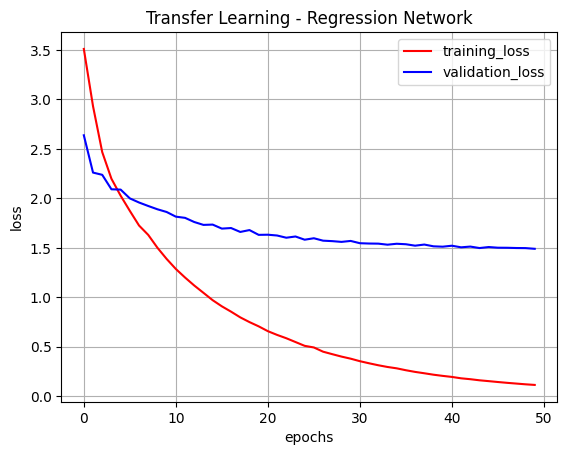

In [ ]:
training_loss = vgg16_transfer_reg_op.history['loss']
val_loss=vgg16_transfer_reg_op.history['val_loss']
training_loss = np.reshape(training_loss, (epoch_num,1))
val_loss = np.reshape(val_loss, (epoch_num,1))

plt.plot(range(epoch_num),training_loss,color = 'red' ,label = "training_loss")
plt.plot(range(epoch_num),val_loss,color = 'blue', label = "validation_loss")

plt.title("Transfer Learning - Regression Network")
plt.xlabel('epochs')
plt.ylabel('loss')

plt.grid(b=True)
plt.legend()
plt.show()

### Plotting the accuracy

/tmp/ipykernel_9786/2221744553.py:13: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


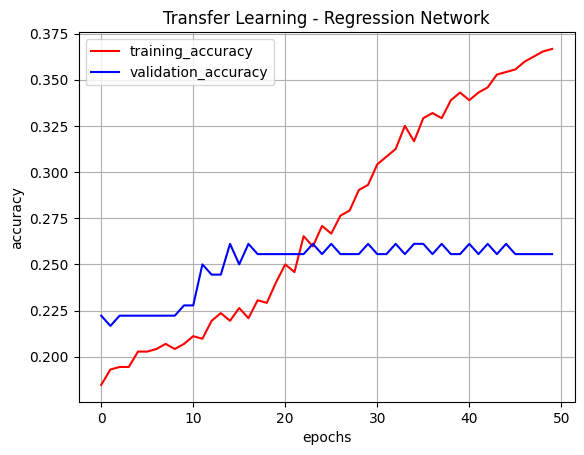

In [ ]:
training_acc = vgg16_transfer_reg_op.history['accuracy']
val_acc=vgg16_transfer_reg_op.history['val_accuracy']
training_acc = np.reshape(training_acc, (epoch_num,1))
val_acc = np.reshape(val_acc, (epoch_num,1))

plt.plot(range(epoch_num),training_acc,color = 'red' ,label = "training_accuracy")
plt.plot(range(epoch_num),val_acc,color = 'blue', label = "validation_accuracy")

plt.title("Transfer Learning - Regression Network")
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.grid(b=True)
plt.legend()
plt.show()

### plotting the confusion matrix

In [ ]:
def cm_reg (case):
  if case == "testing":
    data = test_data
  elif case == "training":
    data = train_data
  elif case == "validation":
    data = validate_data

  predictions = np.abs(np.round(vgg16_transfer_reg.predict(data)))
  y_pred = []
  for pred in predictions:
    if pred < 0.5 :
      pred_save = 0
    elif pred > 0.5 and pred< 1.5:
      pred_save = 1
    elif pred > 1.5 and pred< 2.5:
      pred_save = 2
    elif pred > 2.5 and pred< 3.5:
      pred_save = 3
    elif pred > 3.5:
      pred_save = 4
    y_pred.append(pred_save)
  print(y_pred)

  y = np.concatenate([y for x, y in data], axis=0)

  print("accuracy",accuracy_score(y, y_pred))

  cm_s =confusion_matrix(y, y_pred)
  disp_s = ConfusionMatrixDisplay(confusion_matrix=cm_s, display_labels=[1,2,3,4,6])
  disp_s.plot(cmap=plt.cm.BuPu)
  plt.title('%s confusion matrix'%(case), size=16)


2/2 [==============================] - 0s 69ms/step
[3, 2, 0, 2, 2, 0, 2, 4, 2, 2, 2, 2, 2, 2, 3, 1, 1, 2, 2, 2, 3, 3, 3, 1, 0, 1, 2, 1, 3, 1, 1, 2, 2, 3, 2, 2, 0, 4, 1, 3, 1, 2, 0, 2, 3, 2, 1, 1, 1, 4, 4, 1, 1, 2, 1, 1, 2, 3, 2, 1, 1, 2, 2, 1, 2, 0, 1, 2, 1, 2, 2, 1, 1, 1, 2, 3, 1, 1, 1, 3, 4, 2, 2, 2, 1, 2, 3, 2, 2, 1, 1, 4, 2, 3, 2, 3, 1, 1, 3, 4]
accuracy 0.25


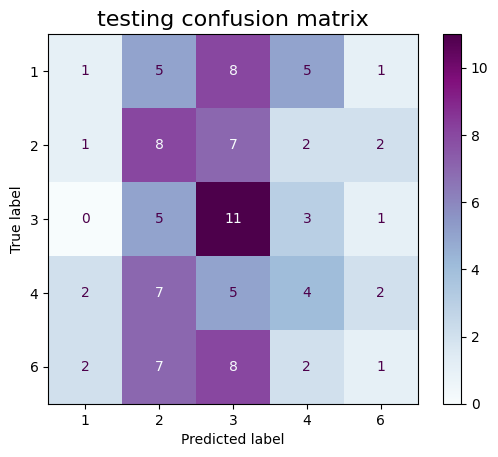

In [ ]:
cm_reg("testing")

12/12 [==============================] - 2s 153ms/step
[1, 3, 1, 2, 1, 2, 4, 3, 1, 1, 0, 1, 1, 0, 1, 2, 1, 3, 1, 3, 1, 3, 0, 4, 2, 3, 4, 0, 2, 2, 2, 0, 0, 3, 0, 0, 1, 3, 2, 2, 2, 1, 0, 4, 2, 2, 2, 0, 2, 2, 1, 3, 1, 3, 1, 3, 0, 3, 2, 1, 1, 4, 3, 2, 4, 2, 3, 4, 2, 4, 3, 3, 2, 1, 4, 0, 2, 1, 2, 2, 1, 2, 0, 0, 0, 2, 0, 1, 2, 3, 2, 4, 1, 1, 3, 0, 0, 3, 3, 1, 4, 0, 1, 0, 3, 1, 2, 0, 3, 3, 2, 0, 1, 3, 3, 0, 2, 0, 1, 3, 0, 1, 2, 4, 0, 2, 3, 4, 3, 3, 0, 2, 3, 1, 2, 1, 3, 0, 3, 4, 0, 1, 1, 1, 2, 2, 4, 3, 4, 2, 1, 3, 3, 1, 4, 3, 1, 2, 3, 4, 0, 2, 4, 3, 4, 0, 2, 1, 0, 1, 2, 2, 4, 1, 4, 1, 4, 3, 2, 0, 3, 1, 0, 1, 4, 0, 4, 0, 3, 1, 2, 3, 0, 3, 3, 2, 3, 2, 2, 1, 4, 3, 4, 2, 0, 2, 1, 1, 4, 0, 1, 3, 1, 0, 3, 2, 1, 3, 4, 1, 0, 3, 4, 0, 3, 2, 1, 3, 2, 1, 3, 1, 3, 1, 1, 1, 4, 4, 4, 1, 1, 2, 0, 4, 3, 3, 2, 1, 0, 1, 0, 1, 1, 2, 1, 3, 1, 1, 3, 2, 1, 4, 0, 0, 3, 3, 4, 1, 3, 0, 0, 3, 3, 2, 1, 3, 1, 1, 3, 1, 3, 0, 4, 4, 4, 2, 0, 3, 0, 1, 1, 1, 3, 2, 4, 0, 1, 2, 3, 3, 3, 0, 1, 0, 2, 1, 0, 0, 3, 0, 3, 1, 3, 1, 0,

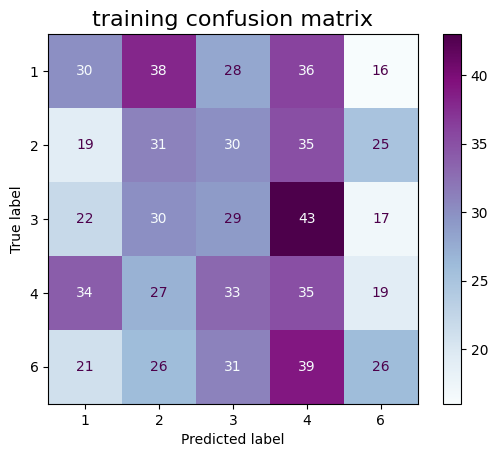

In [ ]:
cm_reg("training")

3/3 [==============================] - 1s 120ms/step
[2, 0, 2, 2, 1, 1, 2, 2, 2, 3, 2, 1, 2, 2, 4, 2, 2, 3, 1, 2, 3, 3, 2, 3, 2, 4, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 0, 2, 3, 0, 2, 2, 2, 1, 2, 2, 3, 1, 2, 3, 1, 1, 3, 3, 2, 2, 2, 1, 3, 2, 2, 3, 2, 3, 2, 0, 3, 3, 1, 2, 2, 2, 1, 1, 2, 1, 3, 2, 1, 1, 2, 1, 2, 1, 4, 2, 2, 1, 3, 3, 2, 2, 2, 1, 0, 4, 2, 4, 3, 0, 1, 1, 1, 2, 2, 0, 2, 1, 2, 1, 1, 1, 3, 2, 2, 3, 2, 3, 2, 2, 3, 1, 0, 3, 2, 1, 3, 0, 1, 2, 3, 2, 0, 2, 3, 2, 3, 1, 4, 4, 3, 2, 2, 1, 2, 2, 2, 3, 1, 3, 2, 3, 2, 2, 2, 3, 2, 2, 4, 1, 3, 3, 2, 1, 1, 2, 2, 2, 1, 0, 1, 1, 4, 2, 1, 2, 1, 2, 2, 1]
accuracy 0.21666666666666667


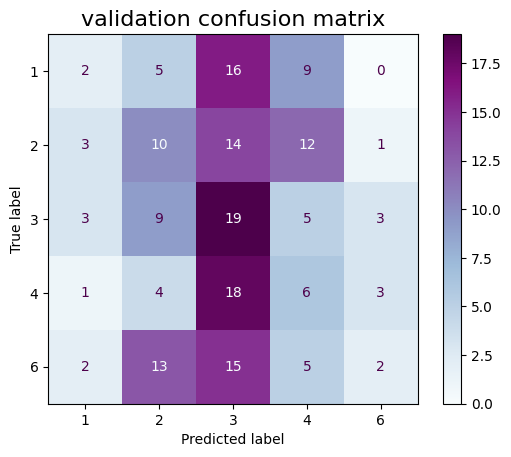

In [ ]:
cm_reg("validation")

### Discussion

It is observed from the previous results that the differance in accuarcy between training and validation is very huge espically in classfication where the training was able to reach 100% accuraccy while the validation stucked at just 40% , this is due to the lack of normalization and regularization also the amount of data isnot enough to properly train the CNN

## Part 2. Improve your Model 

Regularization and data augmentation are common strategies to deal with small datasets.

### Step 1 (1.5)
Incorporate Batch Normalization and Dropout into your design the superior network trained in Part 1.
 

### Step 2 (1.5)
Train the same model from Step 1, now using data augmentation. 

### Step 3 (1)
Discuss based on your learning curves and final metrics in Step 2, how large a improvement can be observed from regularization and data augmentation.

### Normalization

In [ ]:
# Write your code here
vgg16_transfer_norm = Sequential()
vgg16_transfer_norm.add(vgg_16_required)
vgg16_transfer_norm.add(Conv2D(filters=256, kernel_size=(8,8), padding="same", activation='relu'))
vgg16_transfer_norm.add(BatchNormalization())
vgg16_transfer_norm.add(Dropout(0.2))
vgg16_transfer_norm.add(Conv2D(filters=512, kernel_size=(4,4), padding="same", activation='relu'))
vgg16_transfer_norm.add(Dropout(0.2))
vgg16_transfer_norm.add(Conv2D(filters=512, kernel_size=(2,2), padding="same", activation='relu'))
vgg16_transfer_norm.add(BatchNormalization())
vgg16_transfer_norm.add(Dropout(0.2))
vgg16_transfer_norm.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
vgg16_transfer_norm.add(Flatten())
vgg16_transfer_norm.add(Dense(64, activation='relu'))
vgg16_transfer_norm.add(BatchNormalization())
vgg16_transfer_norm.add(Dense(5, activation='softmax'))
vgg16_transfer_norm.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 8, 8, 128)         260160    
                                                                 
 conv2d_18 (Conv2D)          (None, 8, 8, 256)         2097408   
                                                                 
 batch_normalization_18 (Bat  (None, 8, 8, 256)        1024      
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_19 (Conv2D)          (None, 8, 8, 512)         2097664   
                                                                 
 dropout_9 (Dropout)         (None, 8, 8, 512)         0         
                                                      

In [ ]:
vgg16_transfer_norm.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-06), metrics=['accuracy'])

In [ ]:
vgg16_transfer_clf_cb=tf.keras.callbacks.ModelCheckpoint(
    filepath="./weights/vgg16_transfer_norm",
    monitor = "val_loss",
    verbose = 0,
    save_best_only= False,
    save_weights_only= False,
    mode= "auto",
    save_freq="epoch",
    options=None,
    initial_value_threshold=None,
)

In [ ]:
vgg16_transfer_norm_op=vgg16_transfer_norm.fit(train_data, epochs=epoch_num, batch_size=batch,validation_data=validate_data, callbacks=[vgg16_transfer_clf_cb],shuffle=False)

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 2.2503 - accuracy: 0.1903

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 12s 927ms/step - loss: 2.2503 - accuracy: 0.1903 - val_loss: 2.9530 - val_accuracy: 0.2056
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 2.1772 - accuracy: 0.1958

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 11s 891ms/step - loss: 2.1772 - accuracy: 0.1958 - val_loss: 2.2428 - val_accuracy: 0.2056
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 2.2472 - accuracy: 0.2000

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 10s 845ms/step - loss: 2.2472 - accuracy: 0.2000 - val_loss: 1.9356 - val_accuracy: 0.1889
Epoch 4/50
12/12 [==============================] - ETA: 0s - loss: 2.1946 - accuracy: 0.1806

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 12s 962ms/step - loss: 2.1946 - accuracy: 0.1806 - val_loss: 1.7831 - val_accuracy: 0.1944
Epoch 5/50
12/12 [==============================] - ETA: 0s - loss: 2.1704 - accuracy: 0.2167

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 10s 860ms/step - loss: 2.1704 - accuracy: 0.2167 - val_loss: 1.7147 - val_accuracy: 0.1889
Epoch 6/50
12/12 [==============================] - ETA: 0s - loss: 2.1369 - accuracy: 0.2139

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 10s 863ms/step - loss: 2.1369 - accuracy: 0.2139 - val_loss: 1.6849 - val_accuracy: 0.2222
Epoch 7/50
12/12 [==============================] - ETA: 0s - loss: 2.1614 - accuracy: 0.2361

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 11s 929ms/step - loss: 2.1614 - accuracy: 0.2361 - val_loss: 1.6755 - val_accuracy: 0.2500
Epoch 8/50
12/12 [==============================] - ETA: 0s - loss: 2.1406 - accuracy: 0.2056

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 11s 903ms/step - loss: 2.1406 - accuracy: 0.2056 - val_loss: 1.6784 - val_accuracy: 0.2556
Epoch 9/50
12/12 [==============================] - ETA: 0s - loss: 2.1264 - accuracy: 0.2083

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 11s 865ms/step - loss: 2.1264 - accuracy: 0.2083 - val_loss: 1.6846 - val_accuracy: 0.2556
Epoch 10/50
12/12 [==============================] - ETA: 0s - loss: 2.1202 - accuracy: 0.2139

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 12s 975ms/step - loss: 2.1202 - accuracy: 0.2139 - val_loss: 1.6921 - val_accuracy: 0.2500
Epoch 11/50
12/12 [==============================] - ETA: 0s - loss: 2.1101 - accuracy: 0.2264

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 11s 880ms/step - loss: 2.1101 - accuracy: 0.2264 - val_loss: 1.7008 - val_accuracy: 0.2611
Epoch 12/50
12/12 [==============================] - ETA: 0s - loss: 1.9977 - accuracy: 0.2486

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 11s 928ms/step - loss: 1.9977 - accuracy: 0.2486 - val_loss: 1.7088 - val_accuracy: 0.2389
Epoch 13/50
12/12 [==============================] - ETA: 0s - loss: 1.9099 - accuracy: 0.2806

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 11s 938ms/step - loss: 1.9099 - accuracy: 0.2806 - val_loss: 1.7195 - val_accuracy: 0.2278
Epoch 14/50
12/12 [==============================] - ETA: 0s - loss: 2.0417 - accuracy: 0.2681

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 10s 857ms/step - loss: 2.0417 - accuracy: 0.2681 - val_loss: 1.7271 - val_accuracy: 0.2389
Epoch 15/50
12/12 [==============================] - ETA: 0s - loss: 1.9841 - accuracy: 0.2361

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 11s 936ms/step - loss: 1.9841 - accuracy: 0.2361 - val_loss: 1.7308 - val_accuracy: 0.2389
Epoch 16/50
12/12 [==============================] - ETA: 0s - loss: 2.0517 - accuracy: 0.2278

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 11s 896ms/step - loss: 2.0517 - accuracy: 0.2278 - val_loss: 1.7339 - val_accuracy: 0.2444
Epoch 17/50
12/12 [==============================] - ETA: 0s - loss: 1.9850 - accuracy: 0.2486

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 11s 874ms/step - loss: 1.9850 - accuracy: 0.2486 - val_loss: 1.7340 - val_accuracy: 0.2500
Epoch 18/50
12/12 [==============================] - ETA: 0s - loss: 1.9747 - accuracy: 0.2736

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 11s 928ms/step - loss: 1.9747 - accuracy: 0.2736 - val_loss: 1.7301 - val_accuracy: 0.2444
Epoch 19/50
12/12 [==============================] - ETA: 0s - loss: 2.0567 - accuracy: 0.2264

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 11s 899ms/step - loss: 2.0567 - accuracy: 0.2264 - val_loss: 1.7287 - val_accuracy: 0.2667
Epoch 20/50
12/12 [==============================] - ETA: 0s - loss: 1.9466 - accuracy: 0.2653

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 11s 878ms/step - loss: 1.9466 - accuracy: 0.2653 - val_loss: 1.7266 - val_accuracy: 0.2722
Epoch 21/50
12/12 [==============================] - ETA: 0s - loss: 2.0068 - accuracy: 0.2736

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 11s 922ms/step - loss: 2.0068 - accuracy: 0.2736 - val_loss: 1.7245 - val_accuracy: 0.2778
Epoch 22/50
12/12 [==============================] - ETA: 0s - loss: 1.9349 - accuracy: 0.2583

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 11s 892ms/step - loss: 1.9349 - accuracy: 0.2583 - val_loss: 1.7239 - val_accuracy: 0.2833
Epoch 23/50
12/12 [==============================] - ETA: 0s - loss: 1.8848 - accuracy: 0.2819

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 11s 892ms/step - loss: 1.8848 - accuracy: 0.2819 - val_loss: 1.7216 - val_accuracy: 0.2833
Epoch 24/50
12/12 [==============================] - ETA: 0s - loss: 1.9000 - accuracy: 0.2833

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 11s 893ms/step - loss: 1.9000 - accuracy: 0.2833 - val_loss: 1.7178 - val_accuracy: 0.2944
Epoch 25/50
12/12 [==============================] - ETA: 0s - loss: 1.9141 - accuracy: 0.2722

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 11s 866ms/step - loss: 1.9141 - accuracy: 0.2722 - val_loss: 1.7140 - val_accuracy: 0.3000
Epoch 26/50
12/12 [==============================] - ETA: 0s - loss: 1.8571 - accuracy: 0.3111

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 11s 911ms/step - loss: 1.8571 - accuracy: 0.3111 - val_loss: 1.7122 - val_accuracy: 0.3056
Epoch 27/50
12/12 [==============================] - ETA: 0s - loss: 1.8663 - accuracy: 0.2958

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 11s 897ms/step - loss: 1.8663 - accuracy: 0.2958 - val_loss: 1.7110 - val_accuracy: 0.3111
Epoch 28/50
12/12 [==============================] - ETA: 0s - loss: 1.8222 - accuracy: 0.2861

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 10s 858ms/step - loss: 1.8222 - accuracy: 0.2861 - val_loss: 1.7093 - val_accuracy: 0.3111
Epoch 29/50
12/12 [==============================] - ETA: 0s - loss: 1.8029 - accuracy: 0.2875

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 11s 946ms/step - loss: 1.8029 - accuracy: 0.2875 - val_loss: 1.7054 - val_accuracy: 0.3167
Epoch 30/50
12/12 [==============================] - ETA: 0s - loss: 1.8128 - accuracy: 0.2875

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 11s 902ms/step - loss: 1.8128 - accuracy: 0.2875 - val_loss: 1.7021 - val_accuracy: 0.3222
Epoch 31/50
12/12 [==============================] - ETA: 0s - loss: 1.7698 - accuracy: 0.3222

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 10s 853ms/step - loss: 1.7698 - accuracy: 0.3222 - val_loss: 1.6999 - val_accuracy: 0.3167
Epoch 32/50
12/12 [==============================] - ETA: 0s - loss: 1.7195 - accuracy: 0.3417

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 11s 917ms/step - loss: 1.7195 - accuracy: 0.3417 - val_loss: 1.6986 - val_accuracy: 0.3167
Epoch 33/50
12/12 [==============================] - ETA: 0s - loss: 1.8057 - accuracy: 0.2889

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 11s 894ms/step - loss: 1.8057 - accuracy: 0.2889 - val_loss: 1.6963 - val_accuracy: 0.3111
Epoch 34/50
12/12 [==============================] - ETA: 0s - loss: 1.7279 - accuracy: 0.3472

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 10s 863ms/step - loss: 1.7279 - accuracy: 0.3472 - val_loss: 1.6934 - val_accuracy: 0.3111
Epoch 35/50
12/12 [==============================] - ETA: 0s - loss: 1.7472 - accuracy: 0.3167

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 11s 903ms/step - loss: 1.7472 - accuracy: 0.3167 - val_loss: 1.6924 - val_accuracy: 0.2944
Epoch 36/50
12/12 [==============================] - ETA: 0s - loss: 1.8163 - accuracy: 0.3167

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 11s 874ms/step - loss: 1.8163 - accuracy: 0.3167 - val_loss: 1.6902 - val_accuracy: 0.2944
Epoch 37/50
12/12 [==============================] - ETA: 0s - loss: 1.7491 - accuracy: 0.3333

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 11s 881ms/step - loss: 1.7491 - accuracy: 0.3333 - val_loss: 1.6875 - val_accuracy: 0.3000
Epoch 38/50
12/12 [==============================] - ETA: 0s - loss: 1.7948 - accuracy: 0.3042

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 10s 847ms/step - loss: 1.7948 - accuracy: 0.3042 - val_loss: 1.6863 - val_accuracy: 0.2944
Epoch 39/50
12/12 [==============================] - ETA: 0s - loss: 1.7005 - accuracy: 0.3306

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 11s 949ms/step - loss: 1.7005 - accuracy: 0.3306 - val_loss: 1.6822 - val_accuracy: 0.2944
Epoch 40/50
12/12 [==============================] - ETA: 0s - loss: 1.6870 - accuracy: 0.3236

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 12s 1s/step - loss: 1.6870 - accuracy: 0.3236 - val_loss: 1.6812 - val_accuracy: 0.3000
Epoch 41/50
12/12 [==============================] - ETA: 0s - loss: 1.7725 - accuracy: 0.3139

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 12s 990ms/step - loss: 1.7725 - accuracy: 0.3139 - val_loss: 1.6758 - val_accuracy: 0.3000
Epoch 42/50
12/12 [==============================] - ETA: 0s - loss: 1.6758 - accuracy: 0.3403

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 18s 2s/step - loss: 1.6758 - accuracy: 0.3403 - val_loss: 1.6773 - val_accuracy: 0.3056
Epoch 43/50
12/12 [==============================] - ETA: 0s - loss: 1.7627 - accuracy: 0.3125

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 15s 1s/step - loss: 1.7627 - accuracy: 0.3125 - val_loss: 1.6743 - val_accuracy: 0.3278
Epoch 44/50
12/12 [==============================] - ETA: 0s - loss: 1.6283 - accuracy: 0.3847

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 12s 1s/step - loss: 1.6283 - accuracy: 0.3847 - val_loss: 1.6717 - val_accuracy: 0.3333
Epoch 45/50
12/12 [==============================] - ETA: 0s - loss: 1.5937 - accuracy: 0.3556

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 17s 1s/step - loss: 1.5937 - accuracy: 0.3556 - val_loss: 1.6694 - val_accuracy: 0.3333
Epoch 46/50
12/12 [==============================] - ETA: 0s - loss: 1.6636 - accuracy: 0.3514

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 10s 827ms/step - loss: 1.6636 - accuracy: 0.3514 - val_loss: 1.6686 - val_accuracy: 0.3222
Epoch 47/50
12/12 [==============================] - ETA: 0s - loss: 1.6045 - accuracy: 0.3625

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 10s 821ms/step - loss: 1.6045 - accuracy: 0.3625 - val_loss: 1.6671 - val_accuracy: 0.3278
Epoch 48/50
12/12 [==============================] - ETA: 0s - loss: 1.6691 - accuracy: 0.3458

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 11s 926ms/step - loss: 1.6691 - accuracy: 0.3458 - val_loss: 1.6662 - val_accuracy: 0.3111
Epoch 49/50
12/12 [==============================] - ETA: 0s - loss: 1.6360 - accuracy: 0.3514

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 10s 847ms/step - loss: 1.6360 - accuracy: 0.3514 - val_loss: 1.6659 - val_accuracy: 0.3111
Epoch 50/50
12/12 [==============================] - ETA: 0s - loss: 1.6807 - accuracy: 0.3361

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_norm/assets


12/12 [==============================] - 10s 865ms/step - loss: 1.6807 - accuracy: 0.3361 - val_loss: 1.6645 - val_accuracy: 0.3222


#### plotting the loss

(50, 1)


/tmp/ipykernel_9786/157593331.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


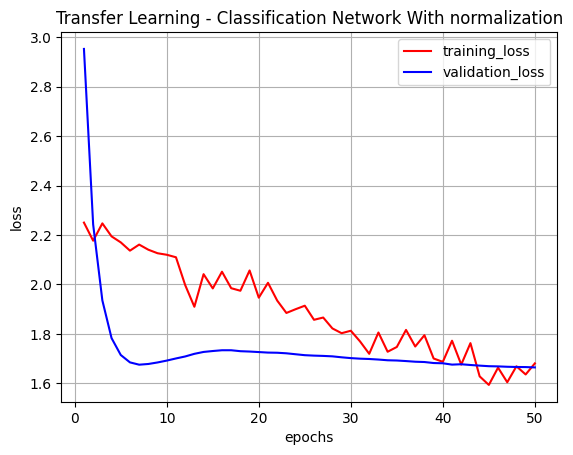

In [ ]:
training_loss = vgg16_transfer_norm_op.history['loss']
val_loss=vgg16_transfer_norm_op.history['val_loss']
training_loss = np.reshape(training_loss, (epoch_num,1))
val_loss = np.reshape(val_loss, (epoch_num,1))

print(np.shape(val_loss))

plt.plot(range(1,epoch_num+1),training_loss,color = 'red' ,label = "training_loss")
plt.plot(range(1,epoch_num+1),val_loss,color = 'blue', label = "validation_loss")

plt.title("Transfer Learning - Classification Network With normalization")
plt.xlabel('epochs')
plt.ylabel('loss')

plt.grid(b=True)
plt.legend()
plt.show()

#### Plotting the accuracy

/tmp/ipykernel_9786/3531218161.py:13: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


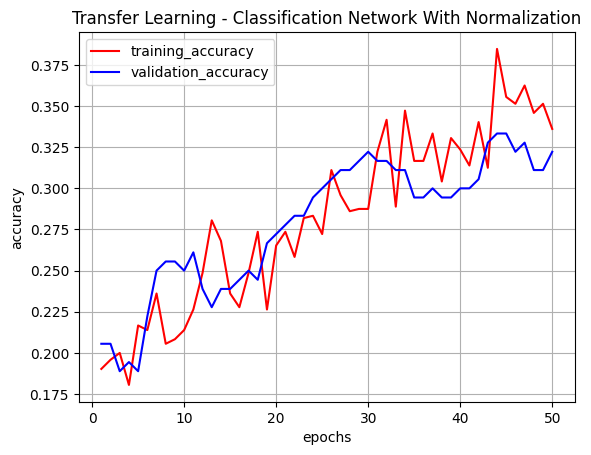

In [ ]:
training_acc = vgg16_transfer_norm_op.history['accuracy']
val_acc=vgg16_transfer_norm_op.history['val_accuracy']
training_acc = np.reshape(training_acc, (epoch_num,1))
val_acc = np.reshape(val_acc, (epoch_num,1))

plt.plot(range(1,epoch_num+1),training_acc,color = 'red' ,label = "training_accuracy")
plt.plot(range(1,epoch_num+1),val_acc,color = 'blue', label = "validation_accuracy")

plt.title("Transfer Learning - Classification Network With Normalization")
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.grid(b=True)
plt.legend()

#### Plotting the confusion matricies

In [ ]:
def cm_norm (case):
  if case == "testing":
    data = test_data
  elif case == "training":
    data = train_data
  elif case == "validation":
    data = validate_data

  predictions = vgg16_transfer_norm.predict(data)    
  y_pred = np.argmax(predictions,axis=1)
  y = np.concatenate([y for x, y in data], axis=0)

  print("accuracy",accuracy_score(y, y_pred))

  cm_s =confusion_matrix(y, y_pred)
  disp_s = ConfusionMatrixDisplay(confusion_matrix=cm_s, display_labels=[1,2,3,4,6])
  disp_s.plot(cmap=plt.cm.BuPu)
  plt.title('%s confusion matrix'%(case), size=16)


2/2 [==============================] - 0s 74ms/step
accuracy 0.27


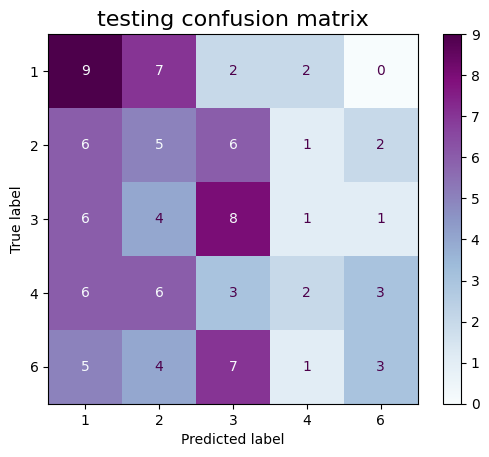

In [ ]:
cm_norm("testing")

12/12 [==============================] - 2s 133ms/step
accuracy 0.18888888888888888


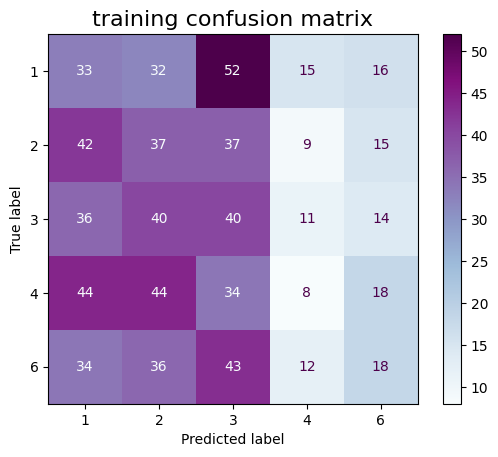

In [ ]:
cm_norm("training")

3/3 [==============================] - 0s 107ms/step
accuracy 0.21666666666666667


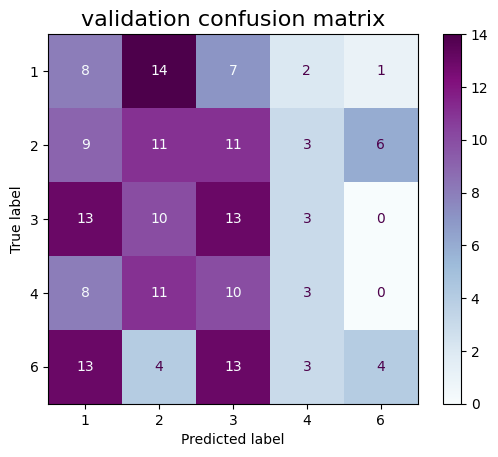

In [ ]:
cm_norm("validation")

### Data augmentation

In [ ]:
def rescale_aug(image):
    image = image/255
    return image

In [ ]:
gen_train = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10., horizontal_flip=True, vertical_flip=True,validation_split=0.2,preprocessing_function=rescale_aug)
gen_test = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10., horizontal_flip=True, vertical_flip=True, preprocessing_function=rescale_aug)

In [ ]:
train_data_aug = gen_train.flow_from_directory(
    directory='training',
    target_size=(32, 32),
    color_mode='rgb',
    class_mode='sparse',
    batch_size=64,
    shuffle=True,
    seed=7,
    subset='training'
)

validate_data_aug = gen_train.flow_from_directory(
    directory='training',
    target_size=(32, 32),
    color_mode='rgb',
    class_mode='sparse',
    batch_size=64,
    shuffle=True,
    seed=7,
    subset='validation'
)

test_data_aug = gen_test.flow_from_directory(
    directory='testing',
    target_size=(32, 32),
    color_mode='rgb',
    class_mode='sparse',
    batch_size=64,
    shuffle=True,
    seed=7
)


Found 720 images belonging to 5 classes.
Found 180 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [ ]:
test_data_aug

In [ ]:
vgg16_transfer_norm.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-06), metrics=['accuracy'])

In [ ]:
vgg16_transfer_clf_cb=tf.keras.callbacks.ModelCheckpoint(
    filepath="./weights/vgg16_transfer_aug",
    monitor = "val_loss",
    verbose = 0,
    save_best_only= False,
    save_weights_only= False,
    mode= "auto",
    save_freq="epoch",
    options=None,
    initial_value_threshold=None,
)

In [ ]:
vgg16_transfer_aug_op=vgg16_transfer_norm.fit(train_data_aug, epochs=epoch_num, batch_size=batch,validation_data=validate_data_aug, callbacks=[vgg16_transfer_clf_cb],shuffle=False)

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 1.4970 - accuracy: 0.4181

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 13s 983ms/step - loss: 1.4970 - accuracy: 0.4181 - val_loss: 17.1577 - val_accuracy: 0.2111
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 1.5396 - accuracy: 0.4014

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 962ms/step - loss: 1.5396 - accuracy: 0.4014 - val_loss: 11.8478 - val_accuracy: 0.2111
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 1.5073 - accuracy: 0.4083

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 882ms/step - loss: 1.5073 - accuracy: 0.4083 - val_loss: 11.7930 - val_accuracy: 0.2444
Epoch 4/50
12/12 [==============================] - ETA: 0s - loss: 1.5302 - accuracy: 0.4000

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 955ms/step - loss: 1.5302 - accuracy: 0.4000 - val_loss: 11.5786 - val_accuracy: 0.2111
Epoch 5/50
12/12 [==============================] - ETA: 0s - loss: 1.4923 - accuracy: 0.4208

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 956ms/step - loss: 1.4923 - accuracy: 0.4208 - val_loss: 10.6709 - val_accuracy: 0.2222
Epoch 6/50
12/12 [==============================] - ETA: 0s - loss: 1.4676 - accuracy: 0.4597

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 924ms/step - loss: 1.4676 - accuracy: 0.4597 - val_loss: 9.5782 - val_accuracy: 0.2111
Epoch 7/50
12/12 [==============================] - ETA: 0s - loss: 1.5093 - accuracy: 0.4347

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 12s 977ms/step - loss: 1.5093 - accuracy: 0.4347 - val_loss: 9.4842 - val_accuracy: 0.2056
Epoch 8/50
12/12 [==============================] - ETA: 0s - loss: 1.5344 - accuracy: 0.4194

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 916ms/step - loss: 1.5344 - accuracy: 0.4194 - val_loss: 8.6721 - val_accuracy: 0.2000
Epoch 9/50
12/12 [==============================] - ETA: 0s - loss: 1.5079 - accuracy: 0.4181

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 938ms/step - loss: 1.5079 - accuracy: 0.4181 - val_loss: 8.1218 - val_accuracy: 0.2000
Epoch 10/50
12/12 [==============================] - ETA: 0s - loss: 1.4431 - accuracy: 0.4403

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 958ms/step - loss: 1.4431 - accuracy: 0.4403 - val_loss: 7.5524 - val_accuracy: 0.2056
Epoch 11/50
12/12 [==============================] - ETA: 0s - loss: 1.6014 - accuracy: 0.3944

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 924ms/step - loss: 1.6014 - accuracy: 0.3944 - val_loss: 6.4085 - val_accuracy: 0.2444
Epoch 12/50
12/12 [==============================] - ETA: 0s - loss: 1.4843 - accuracy: 0.4222

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 12s 998ms/step - loss: 1.4843 - accuracy: 0.4222 - val_loss: 5.4188 - val_accuracy: 0.2167
Epoch 13/50
12/12 [==============================] - ETA: 0s - loss: 1.5283 - accuracy: 0.4111

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 939ms/step - loss: 1.5283 - accuracy: 0.4111 - val_loss: 5.0853 - val_accuracy: 0.2389
Epoch 14/50
12/12 [==============================] - ETA: 0s - loss: 1.5340 - accuracy: 0.4125

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 894ms/step - loss: 1.5340 - accuracy: 0.4125 - val_loss: 4.3679 - val_accuracy: 0.2611
Epoch 15/50
12/12 [==============================] - ETA: 0s - loss: 1.5125 - accuracy: 0.4181

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 12s 1s/step - loss: 1.5125 - accuracy: 0.4181 - val_loss: 3.8579 - val_accuracy: 0.2444
Epoch 16/50
12/12 [==============================] - ETA: 0s - loss: 1.4951 - accuracy: 0.4403

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 929ms/step - loss: 1.4951 - accuracy: 0.4403 - val_loss: 3.4039 - val_accuracy: 0.2722
Epoch 17/50
12/12 [==============================] - ETA: 0s - loss: 1.5243 - accuracy: 0.4153

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 912ms/step - loss: 1.5243 - accuracy: 0.4153 - val_loss: 3.0098 - val_accuracy: 0.2778
Epoch 18/50
12/12 [==============================] - ETA: 0s - loss: 1.4736 - accuracy: 0.4250

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 12s 969ms/step - loss: 1.4736 - accuracy: 0.4250 - val_loss: 2.4510 - val_accuracy: 0.2833
Epoch 19/50
12/12 [==============================] - ETA: 0s - loss: 1.4854 - accuracy: 0.4083

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 12s 962ms/step - loss: 1.4854 - accuracy: 0.4083 - val_loss: 2.7303 - val_accuracy: 0.2778
Epoch 20/50
12/12 [==============================] - ETA: 0s - loss: 1.4302 - accuracy: 0.4625

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 937ms/step - loss: 1.4302 - accuracy: 0.4625 - val_loss: 2.4457 - val_accuracy: 0.2722
Epoch 21/50
12/12 [==============================] - ETA: 0s - loss: 1.5665 - accuracy: 0.4056

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 913ms/step - loss: 1.5665 - accuracy: 0.4056 - val_loss: 2.1146 - val_accuracy: 0.3222
Epoch 22/50
12/12 [==============================] - ETA: 0s - loss: 1.4852 - accuracy: 0.4264

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 946ms/step - loss: 1.4852 - accuracy: 0.4264 - val_loss: 2.1518 - val_accuracy: 0.2889
Epoch 23/50
12/12 [==============================] - ETA: 0s - loss: 1.4492 - accuracy: 0.4389

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 12s 980ms/step - loss: 1.4492 - accuracy: 0.4389 - val_loss: 1.9527 - val_accuracy: 0.3389
Epoch 24/50
12/12 [==============================] - ETA: 0s - loss: 1.5145 - accuracy: 0.4139

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 927ms/step - loss: 1.5145 - accuracy: 0.4139 - val_loss: 1.8892 - val_accuracy: 0.3222
Epoch 25/50
12/12 [==============================] - ETA: 0s - loss: 1.4811 - accuracy: 0.4292

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 897ms/step - loss: 1.4811 - accuracy: 0.4292 - val_loss: 1.7680 - val_accuracy: 0.3556
Epoch 26/50
12/12 [==============================] - ETA: 0s - loss: 1.4641 - accuracy: 0.4528

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 12s 1s/step - loss: 1.4641 - accuracy: 0.4528 - val_loss: 1.5809 - val_accuracy: 0.3611
Epoch 27/50
12/12 [==============================] - ETA: 0s - loss: 1.4564 - accuracy: 0.4306

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 917ms/step - loss: 1.4564 - accuracy: 0.4306 - val_loss: 1.5965 - val_accuracy: 0.3667
Epoch 28/50
12/12 [==============================] - ETA: 0s - loss: 1.4513 - accuracy: 0.4375

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 916ms/step - loss: 1.4513 - accuracy: 0.4375 - val_loss: 1.5817 - val_accuracy: 0.3833
Epoch 29/50
12/12 [==============================] - ETA: 0s - loss: 1.4605 - accuracy: 0.4375

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 12s 958ms/step - loss: 1.4605 - accuracy: 0.4375 - val_loss: 1.5909 - val_accuracy: 0.3611
Epoch 30/50
12/12 [==============================] - ETA: 0s - loss: 1.4782 - accuracy: 0.4264

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 913ms/step - loss: 1.4782 - accuracy: 0.4264 - val_loss: 1.5088 - val_accuracy: 0.3722
Epoch 31/50
12/12 [==============================] - ETA: 0s - loss: 1.4707 - accuracy: 0.4250

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 904ms/step - loss: 1.4707 - accuracy: 0.4250 - val_loss: 1.5620 - val_accuracy: 0.3611
Epoch 32/50
12/12 [==============================] - ETA: 0s - loss: 1.5221 - accuracy: 0.4306

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 12s 1s/step - loss: 1.5221 - accuracy: 0.4306 - val_loss: 1.5028 - val_accuracy: 0.4444
Epoch 33/50
12/12 [==============================] - ETA: 0s - loss: 1.4709 - accuracy: 0.4319

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 925ms/step - loss: 1.4709 - accuracy: 0.4319 - val_loss: 1.4112 - val_accuracy: 0.4333
Epoch 34/50
12/12 [==============================] - ETA: 0s - loss: 1.4556 - accuracy: 0.4278

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 900ms/step - loss: 1.4556 - accuracy: 0.4278 - val_loss: 1.5414 - val_accuracy: 0.4167
Epoch 35/50
12/12 [==============================] - ETA: 0s - loss: 1.5143 - accuracy: 0.4083

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 12s 1s/step - loss: 1.5143 - accuracy: 0.4083 - val_loss: 1.4358 - val_accuracy: 0.4167
Epoch 36/50
12/12 [==============================] - ETA: 0s - loss: 1.4824 - accuracy: 0.4292

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 915ms/step - loss: 1.4824 - accuracy: 0.4292 - val_loss: 1.2464 - val_accuracy: 0.4778
Epoch 37/50
12/12 [==============================] - ETA: 0s - loss: 1.4483 - accuracy: 0.4139

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 903ms/step - loss: 1.4483 - accuracy: 0.4139 - val_loss: 1.3326 - val_accuracy: 0.4333
Epoch 38/50
12/12 [==============================] - ETA: 0s - loss: 1.4716 - accuracy: 0.4514

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 966ms/step - loss: 1.4716 - accuracy: 0.4514 - val_loss: 1.4183 - val_accuracy: 0.4167
Epoch 39/50
12/12 [==============================] - ETA: 0s - loss: 1.4254 - accuracy: 0.4389

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 947ms/step - loss: 1.4254 - accuracy: 0.4389 - val_loss: 1.3635 - val_accuracy: 0.4389
Epoch 40/50
12/12 [==============================] - ETA: 0s - loss: 1.4726 - accuracy: 0.4236

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 955ms/step - loss: 1.4726 - accuracy: 0.4236 - val_loss: 1.5259 - val_accuracy: 0.3944
Epoch 41/50
12/12 [==============================] - ETA: 0s - loss: 1.4413 - accuracy: 0.4278

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 923ms/step - loss: 1.4413 - accuracy: 0.4278 - val_loss: 1.2958 - val_accuracy: 0.4611
Epoch 42/50
12/12 [==============================] - ETA: 0s - loss: 1.4314 - accuracy: 0.4361

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 945ms/step - loss: 1.4314 - accuracy: 0.4361 - val_loss: 1.3825 - val_accuracy: 0.4500
Epoch 43/50
12/12 [==============================] - ETA: 0s - loss: 1.4164 - accuracy: 0.4417

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 12s 1s/step - loss: 1.4164 - accuracy: 0.4417 - val_loss: 1.3011 - val_accuracy: 0.4833
Epoch 44/50
12/12 [==============================] - ETA: 0s - loss: 1.3759 - accuracy: 0.4597

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 930ms/step - loss: 1.3759 - accuracy: 0.4597 - val_loss: 1.2740 - val_accuracy: 0.4333
Epoch 45/50
12/12 [==============================] - ETA: 0s - loss: 1.4184 - accuracy: 0.4514

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 956ms/step - loss: 1.4184 - accuracy: 0.4514 - val_loss: 1.3399 - val_accuracy: 0.4333
Epoch 46/50
12/12 [==============================] - ETA: 0s - loss: 1.4503 - accuracy: 0.4278

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 968ms/step - loss: 1.4503 - accuracy: 0.4278 - val_loss: 1.3393 - val_accuracy: 0.4556
Epoch 47/50
12/12 [==============================] - ETA: 0s - loss: 1.4018 - accuracy: 0.4556

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 925ms/step - loss: 1.4018 - accuracy: 0.4556 - val_loss: 1.3116 - val_accuracy: 0.4444
Epoch 48/50
12/12 [==============================] - ETA: 0s - loss: 1.4746 - accuracy: 0.4306

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 933ms/step - loss: 1.4746 - accuracy: 0.4306 - val_loss: 1.3904 - val_accuracy: 0.4444
Epoch 49/50
12/12 [==============================] - ETA: 0s - loss: 1.4177 - accuracy: 0.4347

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 953ms/step - loss: 1.4177 - accuracy: 0.4347 - val_loss: 1.3335 - val_accuracy: 0.4278
Epoch 50/50
12/12 [==============================] - ETA: 0s - loss: 1.4236 - accuracy: 0.4583

INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


INFO:tensorflow:Assets written to: ./weights/vgg16_transfer_aug/assets


12/12 [==============================] - 11s 900ms/step - loss: 1.4236 - accuracy: 0.4583 - val_loss: 1.4207 - val_accuracy: 0.4167


#### Plotting the loss

(50, 1)


/tmp/ipykernel_9786/3275055375.py:15: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


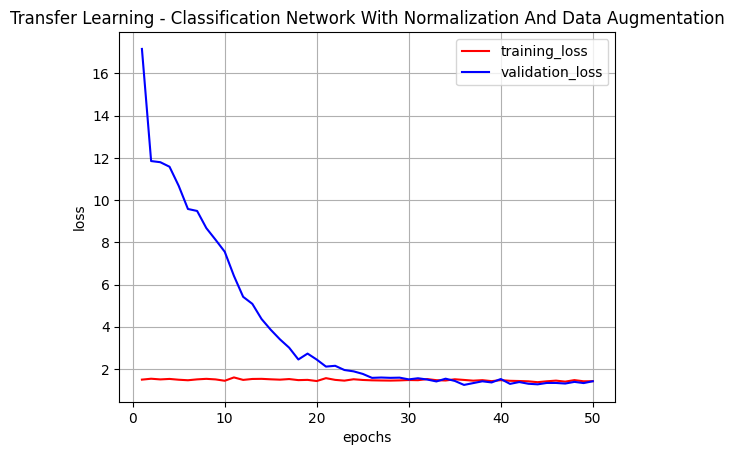

In [ ]:
training_loss = vgg16_transfer_aug_op.history['loss']
val_loss=vgg16_transfer_aug_op.history['val_loss']
training_loss = np.reshape(training_loss, (epoch_num,1))
val_loss = np.reshape(val_loss, (epoch_num,1))

print(np.shape(val_loss))

plt.plot(range(1,epoch_num+1),training_loss,color = 'red' ,label = "training_loss")
plt.plot(range(1,epoch_num+1),val_loss,color = 'blue', label = "validation_loss")

plt.title("Transfer Learning - Classification Network With Normalization And Data Augmentation")
plt.xlabel('epochs')
plt.ylabel('loss')

plt.grid(b=True)
plt.legend()
plt.show()

#### Plotting the accuracy

/tmp/ipykernel_9786/3034374815.py:13: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


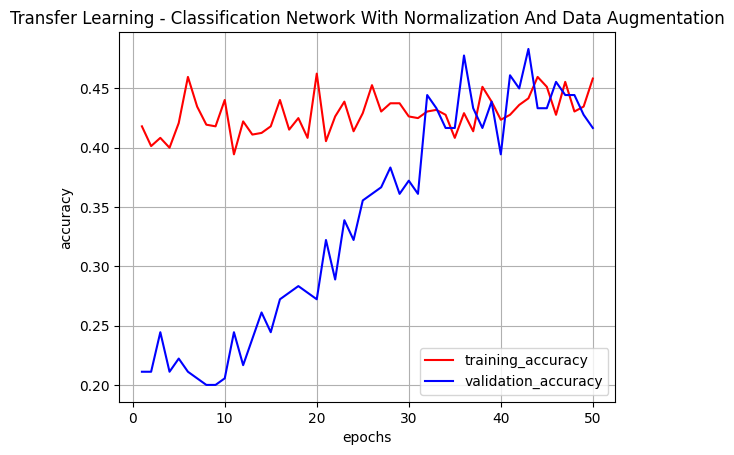

In [ ]:
training_acc = vgg16_transfer_aug_op.history['accuracy']
val_acc=vgg16_transfer_aug_op.history['val_accuracy']
training_acc = np.reshape(training_acc, (epoch_num,1))
val_acc = np.reshape(val_acc, (epoch_num,1))

plt.plot(range(1,epoch_num+1),training_acc,color = 'red' ,label = "training_accuracy")
plt.plot(range(1,epoch_num+1),val_acc,color = 'blue', label = "validation_accuracy")

plt.title("Transfer Learning - Classification Network With Normalization And Data Augmentation")
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.grid(b=True)
plt.legend()

#### Plotting the confusion matrix

In [ ]:
def cm_aug (case):
  if case == "testing":
    data = test_data_aug
  elif case == "training":
    data = train_data_aug
  elif case == "validation":
    data = validate_data_aug

  predictions = vgg16_transfer_norm.predict(data)   
  y_pred = np.argmax(predictions,axis=1)
  y = data.labels
  print("accuracy",accuracy_score(y, y_pred))

  cm_s =confusion_matrix(y, y_pred)
  disp_s = ConfusionMatrixDisplay(confusion_matrix=cm_s, display_labels=[1,2,3,4,6])
  disp_s.plot(cmap=plt.cm.BuPu)
  plt.title('%s confusion matrix'%(case), size=16)

2/2 [==============================] - 0s 102ms/step
accuracy 0.17


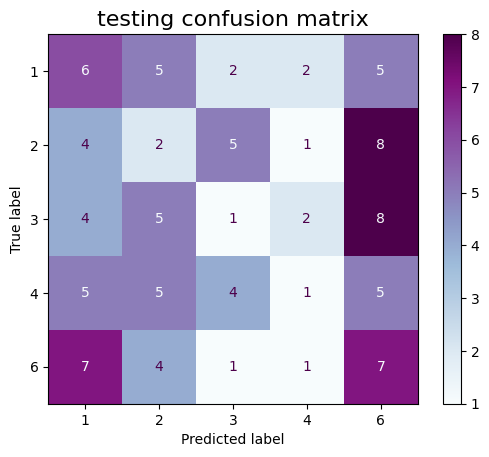

In [ ]:
cm_aug("testing")

12/12 [==============================] - 2s 169ms/step
accuracy 0.18194444444444444


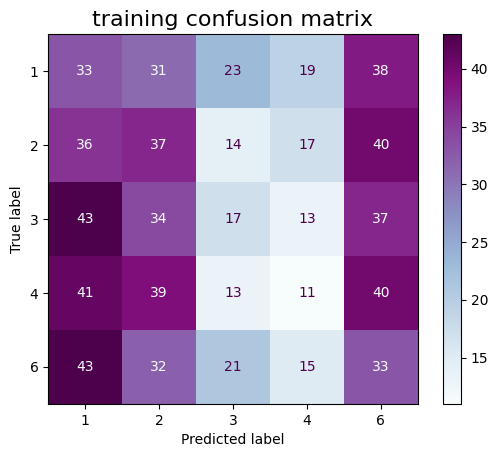

In [ ]:
cm_aug("training")

3/3 [==============================] - 1s 194ms/step
accuracy 0.21666666666666667


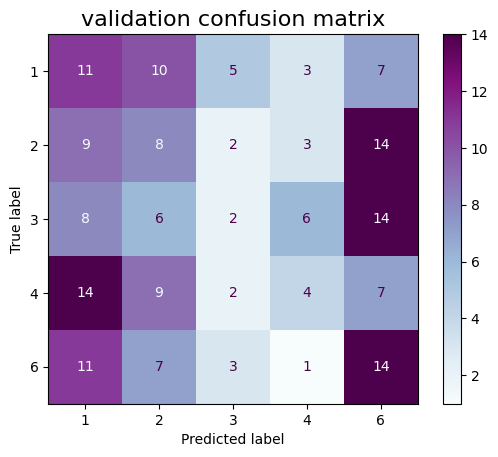

In [ ]:
cm_aug("validation")

### Discussion

It is observed that eventhough the training accuracy has decreased signfically the validation accuracy has increased and was able to keep up with the training accuracy <br/> In normalizationa it can be observed that the training accuracy is increasing along sid the validation accuracy until reaching 38% while te validation reached 33% which is not a huge differance compared to the first part <br/>
However, In augmentaion the training accuracy was high from the beginning as the added data helped in the training process leading the training accuracy to reach 45% and on its way to rising and the validation was able to keep up with it reaching 42% 


## References
[1] N. Teimouri, M. Dyrmann, P. R. Nielsen, S. K. Mathiassen, G. J. Somerville, and R. N. Jørgensen, “Weed growth stage estimator using deep convolutional neural networks,” Sensors, vol. 18, no. 5, 2018.